In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Train/Vandalism/Vandalism035_x264_230.png  
  inflating: Train/Vandalism/Vandalism035_x264_240.png  
  inflating: Train/Vandalism/Vandalism035_x264_250.png  
  inflating: Train/Vandalism/Vandalism035_x264_260.png  
  inflating: Train/Vandalism/Vandalism035_x264_270.png  
  inflating: Train/Vandalism/Vandalism035_x264_280.png  
  inflating: Train/Vandalism/Vandalism035_x264_290.png  
  inflating: Train/Vandalism/Vandalism035_x264_30.png  
  inflating: Train/Vandalism/Vandalism035_x264_300.png  
  inflating: Train/Vandalism/Vandalism035_x264_310.png  
  inflating: Train/Vandalism/Vandalism035_x264_320.png  
  inflating: Train/Vandalism/Vandalism035_x264_330.png  
  inflating: Train/Vandalism/Vandalism035_x264_340.png  
  inflating: Train/Vandalism/Vandalism035_x264_350.png  
  inflating: Train/Vandalism/Vandalism035_x264_360.png  
  inflating: Train/Vandalism/Vandalism035_x264_370.png  
  inflating: Train/Vandalism/Vandalism

In [ ]:
train_dir= "/content/Train"
test_dir= "/content/Test"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten
from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 128
EPOCHS = 1
LR =  0.00003


In [ ]:
crime_types=os.listdir(train_dir)
n=len(crime_types)
print("Number of crime categories : ",n)

Number of crime categories :  14


In [ ]:
crimes={}
train=test=0
for clss in crime_types:
    num=len(os.listdir(os.path.join(train_dir,clss)))
    train+=num
    test+=len(os.listdir(os.path.join(test_dir,clss)))

    crimes[clss]=num

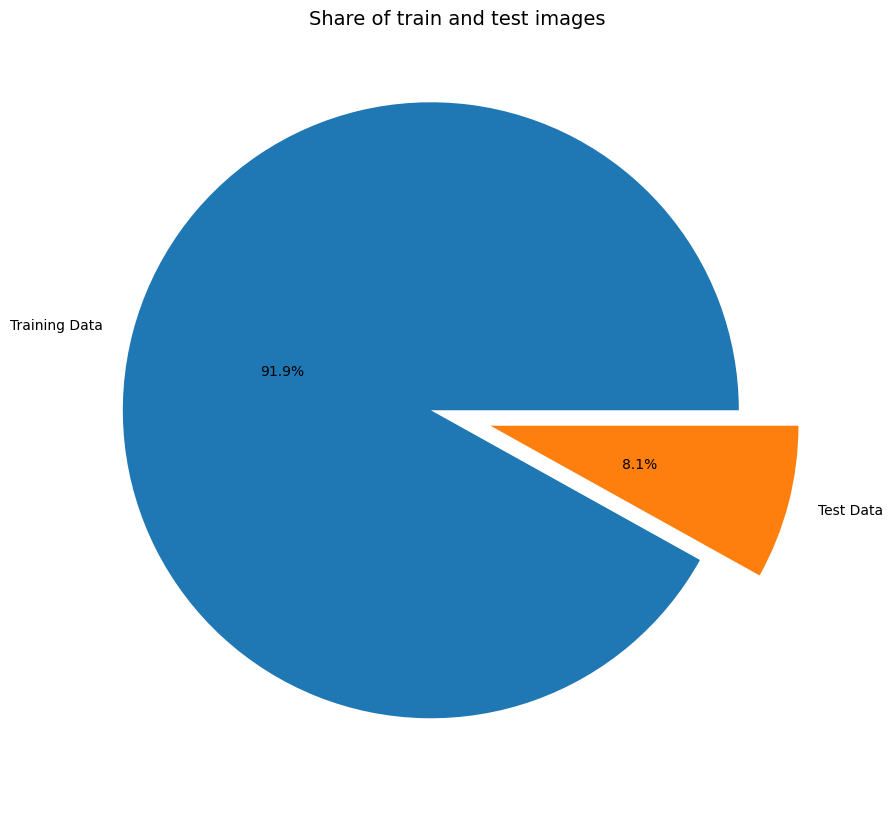

In [ ]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([train,test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

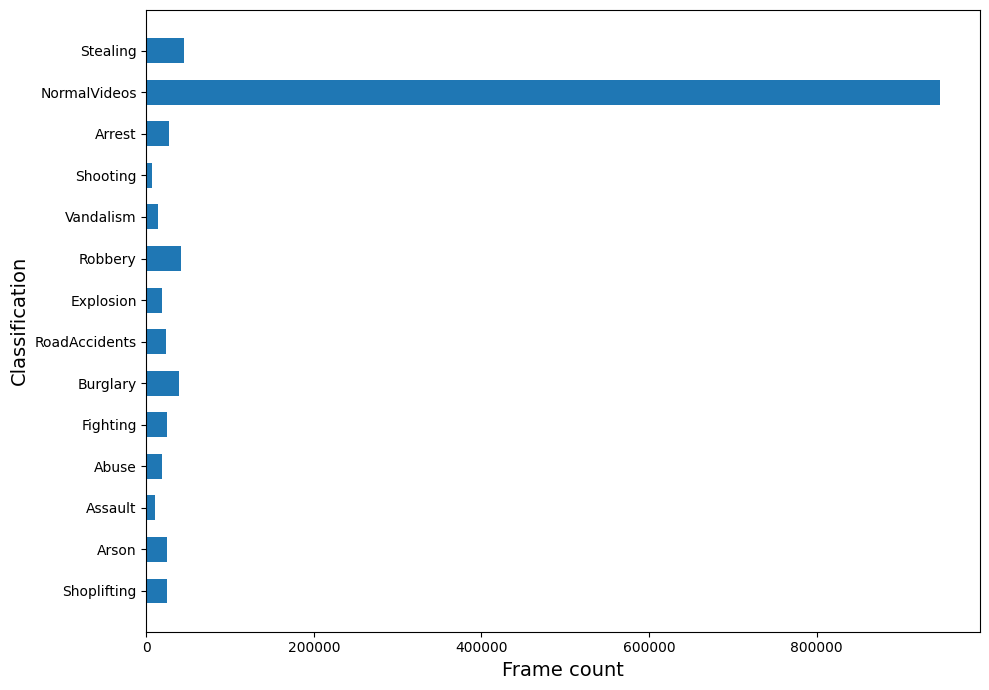

In [ ]:
plt.figure(figsize=(10, 7))
plt.barh(list(crimes.keys()), list(crimes.values()), height=0.6, align="center")
plt.yticks(rotation=0)

plt.xlabel("Frame count", fontsize=14)
plt.ylabel("Classification", fontsize=14)
plt.tight_layout()
plt.show()

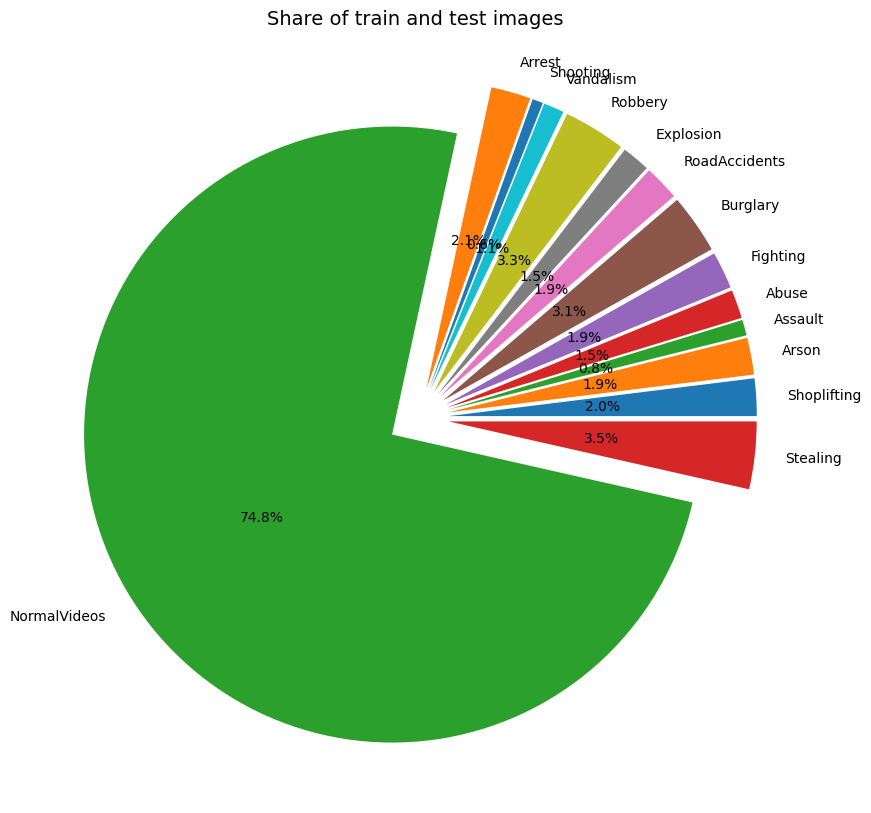

In [ ]:
plt.figure(figsize=(15,10))
plt.pie(x=np.array(list(crimes.values())), autopct="%.1f%%", explode=[0.1]*n,labels=list(crimes.keys()), pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

In [ ]:
IMG_WIDTH=64
IMG_HEIGHT=64

IMG_SHAPE=(IMG_HEIGHT,IMG_WIDTH)
seed=69

INPUT_SHAPE=(IMG_HEIGHT,IMG_WIDTH,3)

In [ ]:
train_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
)

val_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

test_set=image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=seed,
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.
Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.
Found 111308 files belonging to 14 classes.


In [ ]:
def transfer_learning():
    base_model=DenseNet121(include_top=False,input_shape=INPUT_SHAPE,weights="imagenet")

    thr=149
    for layers in base_model.layers[:thr]:
        layers.trainable=False

    for layers in base_model.layers[thr:]:
        layers.trainable=True

    return base_model

In [ ]:
def transfer_learning():
    base_model=DenseNet121(include_top=False,input_shape=INPUT_SHAPE,weights="imagenet")

    thr=149
    for layers in base_model.layers[:thr]:
        layers.trainable=False

    for layers in base_model.layers[thr:]:
        layers.trainable=True

    return base_model

In [ ]:
def create_model():
    model=Sequential()

    base_model=transfer_learning()
    model.add(base_model)

    model.add(GlobalAveragePooling2D())

    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))

    model.add(Dense(n,activation="softmax",name="classification"))

    model.summary()

    return model

In [ ]:
model=create_model()

model.compile(optimizer="adam",
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])

29084464/29084464 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 classification (Dense)      (None, 14)                1806      
                                                                 
Total params: 7,170,510
Trainable params: 5,586,254
Non-t

In [ ]:
history = model.fit(x = train_set,validation_data=val_set,epochs = 5)

Epoch 1/5
7915/7915 [==============================] - 1538s 185ms/step - loss: 0.0597 - auc: 0.9991 - val_loss: 0.0207 - val_auc: 0.9998
Epoch 2/5
7915/7915 [==============================] - 1468s 185ms/step - loss: 0.0173 - auc: 0.9998 - val_loss: 0.0124 - val_auc: 0.9998
Epoch 3/5
7915/7915 [==============================] - 1463s 185ms/step - loss: 0.0119 - auc: 0.9998 - val_loss: 0.0119 - val_auc: 0.9998
Epoch 4/5
7915/7915 [==============================] - 1394s 176ms/step - loss: 0.0095 - auc: 0.9999 - val_loss: 0.0097 - val_auc: 0.9998
Epoch 5/5
7915/7915 [==============================] - 1404s 177ms/step - loss: 0.0081 - auc: 0.9999 - val_loss: 0.0063 - val_auc: 0.9999


In [ ]:
y_true =  np.array([])

for x, y in test_set:
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

In [ ]:
y_pred=model.predict(test_set)

870/870 [==============================] - 55s 60ms/step


In [ ]:
y_pred

array([[1.7943124e-07, 2.2735847e-04, 5.0801823e-06, ..., 3.2056441e-08,
        5.4237594e-06, 1.4433796e-03],
       [4.3339483e-07, 1.8299722e-04, 6.6082898e-06, ..., 7.8135443e-08,
        9.5494570e-06, 7.2307848e-05],
       [4.4585890e-05, 1.3184070e-04, 3.9034653e-06, ..., 1.5193031e-06,
        3.2737782e-05, 2.8710892e-05],
       ...,
       [2.3713840e-09, 3.2892715e-09, 1.2164475e-06, ..., 3.6688647e-10,
        2.2928610e-11, 6.9045969e-10],
       [4.2270827e-09, 3.4665815e-09, 5.1098737e-06, ..., 1.0294132e-09,
        9.2641707e-11, 1.4800835e-09],
       [5.4389426e-07, 8.7127842e-07, 1.0981677e-04, ..., 1.2809730e-07,
        5.5504042e-08, 1.0594607e-06]], dtype=float32)

In [ ]:
y_true

array([ 0.,  0.,  0., ..., 13., 13., 13.])

In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(crime_types):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.8350493686650251


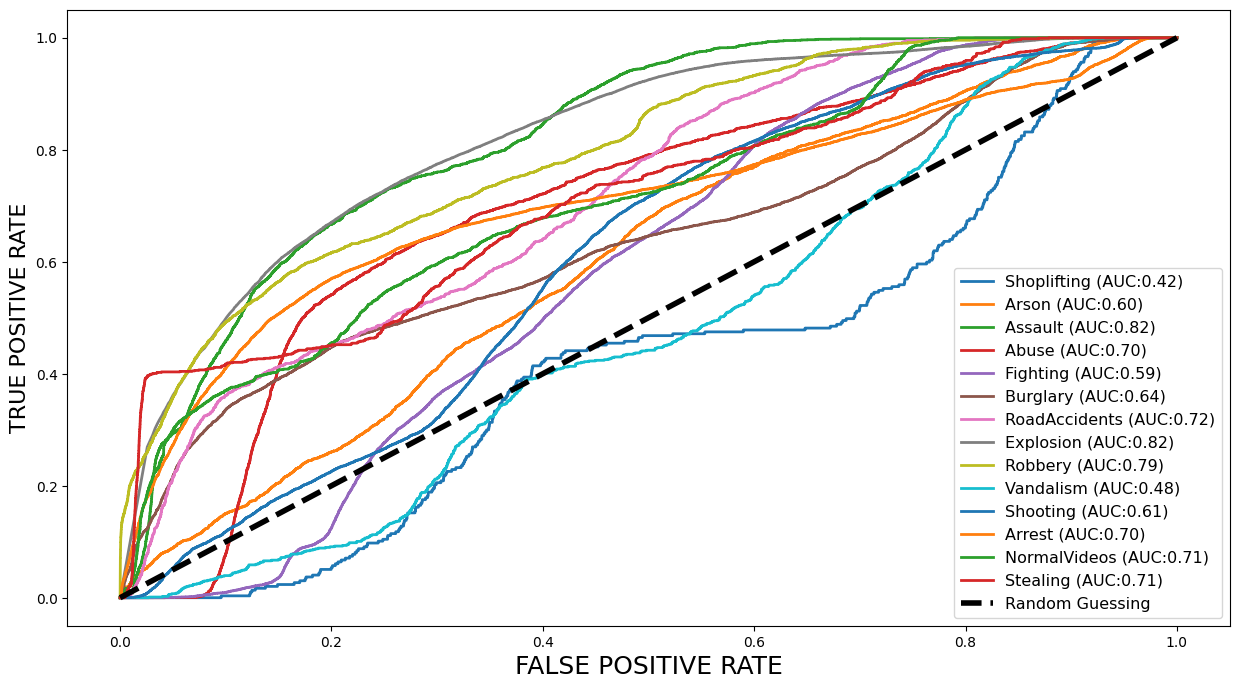

In [ ]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))


print('ROC AUC score:', multiclass_roc_auc_score(y_true , y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [ ]:
model.save("crime1.h5")

In [ ]:
model.save("/content/drive/MyDrive/crime1.h5")

In [ ]:
from tensorflow.keras.models import load_model
model.load_weights('/content/crime1.h5')

In [ ]:
y_true= np.array([])
for x,y in test_set:
  y_true=np.concatenate([y_true,np.argmax(y.numpy(),axis=-1)])

In [ ]:
y_true

array([ 0.,  0.,  0., ..., 13., 13., 13.])

In [ ]:
import keras.utils as image
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
img= image.load_img("/content/Test/Abuse/Abuse028_x264_1070.png",target_size=(64,64))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
pred=np.argmax(model.predict(x))
op=['Fighting','Burglary','Vandalism','Assault','Stealing','RoadAccidents','NormalVideos','Explosion','Abuse','Robbery','Arrest','Shooting','Shoplifting','Arson']
print(pred)
op[pred]

1/1 [==============================] - 4s 4s/step
8


'Abuse'

In [ ]:
img= image.load_img("/content/Test/Arson/Arson007_x264_1110.png",target_size=(64,64))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
pred=np.argmax(model.predict(x))
op=['Fighting','Burglary','Vandalism','Assault','Stealing','RoadAccidents','NormalVideos','Explosion','Abuse','Robbery','Arrest','Shooting','Shoplifting','Arson']
print(pred)
op[pred]

1/1 [==============================] - 0s 33ms/step
13


'Arson'

In [ ]:
img= image.load_img("/content/Test/Arrest/Arrest007_x264_10.png",target_size=(64,64))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
pred=np.argmax(model.predict(x))
op=['Fighting','Burglary','Vandalism','Assault','Stealing','RoadAccidents','NormalVideos','Explosion','Abuse','Robbery','Arrest','Shooting','Shoplifting','Arson']
print(pred)
op[pred]

1/1 [==============================] - 0s 33ms/step
1


'Arrest'